<b>Neural Nets: Auto Encoder and Domain Adaptation</b>

In this lab you will learn how to use neural nets in a setting where we use a pretrained model (trained on a big data set) for a slightly different task as initialization (in this tutorial a neural net that can recognize the digits 0-7). Building a model on top of a pretrained model (training a neural net to recognize the digits 8 and 9) by only fine tuning the initial weights can give better results than training a neural net from scratch. This technique is known as domain adaptation. Furthermore we will look at autoencoders and how they can be used for denoising data.

In [1]:
# imports
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# nn
from keras import backend as K
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

# image manipulation
import cv2

%matplotlib inline

Using TensorFlow backend.


<b>1. Part: Domain Adaptation</b>

First of all, we load the data set (handwritten digit data set) and rescale all data points as in the tutorial before.

In [2]:
# load digit dataset with training and test images
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# rescale the data
x_train = x_train / 255.
x_test = x_test / 255.
# dimension
img_rows, img_cols = x_train[0].shape

In [3]:
# transform data set
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Now we create two slightly different task by dividing the data into two data sets. The first data set contains all images for the digits ranging from 0 to 7. The second data set contains images with images of handwritten 8's and 9's. For the second data set we only use the first 10 instances in the training part of the data set.

In [4]:
# get all images from class 0-7 and 8/9
x_train_0to7 = x_train[np.logical_and(y_train != 8,y_train != 9)]
x_train_8and9 = x_train[np.logical_or(y_train == 8,y_train == 9)]
y_train_0to7 = y_train[np.logical_and(y_train != 8,y_train != 9)]
y_train_8and9 = y_train[np.logical_or(y_train == 8,y_train == 9)]

# only use small subset of training set (#num_instances training images per class)
num_instances = 10
idx_8 = np.where(y_train_8and9 == 8)[0]
idx_9 = np.where(y_train_8and9 == 9)[0]
x_train_8and9 = x_train_8and9[np.concatenate([idx_8[0:num_instances],idx_9[0:num_instances]]),:]
y_train_8and9 = y_train_8and9[np.concatenate([idx_8[0:num_instances],idx_9[0:num_instances]])]

# get all images for the test data
x_test_0to7 = x_test[np.logical_and(y_test != 8,y_test != 9)]
x_test_8and9 = x_test[np.logical_or(y_test == 8,y_test == 9)]
y_test_0to7 = y_test[np.logical_and(y_test != 8,y_test != 9)]
y_test_8and9 = y_test[np.logical_or(y_test == 8,y_test == 9)]

<b>Excercise 1</b>

Write the python code to show the first 10 instances of the training data set for the problem of recognizing the digits from 0 to 7 and the first 10 instances for the second problem of recognizing the digits 8 and 9.

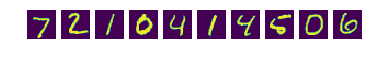

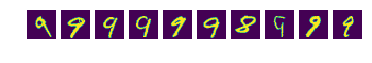

In [5]:
# 0 to 7
for i in range(num_instances):
    plt.subplot(2, num_instances, i + 1)
    plt.axis('off')
    plt.imshow(x_test_0to7[i, :, :, 0])
plt.show()

# 8 and 9
for i in range(num_instances):
    plt.subplot(2, num_instances, i + 1)
    plt.axis('off')
    plt.imshow(x_test_8and9[i, :, :, 0])
plt.show()

The model to detect handwritten digits is defined as shown in tutorial last week. Because we want to train a model to distinguish between the digits from 0 to 7 we only have 8 different classes. This model will be the basis and will be finetuned on the dataset of only two different digits 8 and 9.

In [6]:
def getSimpleCNN(nb_classes=8):
    # domain adaptation neural net
    nb_filters_one = 32
    nb_filters_two = 64
    nb_conv = 3
    nb_pool = 2
    dense_size = 128
    cnnModel = Sequential()
    cnnModel.add(Conv2D(nb_filters_one, kernel_size=(nb_conv, nb_conv),
                     activation='relu',
                     input_shape=input_shape,name='conv'))
    #cnnModel.add(Conv2D(nb_filters_two, (nb_conv, nb_conv), activation='relu'))
    cnnModel.add(MaxPooling2D(pool_size=(nb_pool, nb_pool),name='max'))
    cnnModel.add(Dropout(0.25))
    cnnModel.add(Flatten())
    cnnModel.add(Dense(dense_size, activation='relu',name='dense'))
    cnnModel.add(Dropout(0.5))
    cnnModel.add(Dense(nb_classes, activation='softmax'))

    cnnModel.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return cnnModel
cnnModel = getSimpleCNN()
cnnModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 26, 26, 32)        320       
_________________________________________________________________
max (MaxPooling2D)           (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total para

Now we train our model for 10 epochs.

In [7]:
batch_size = 128
encoder = LabelEncoder().fit(y_train_0to7)
oneHotLabelTrain = np_utils.to_categorical(encoder.transform(y_train_0to7), len(np.unique(y_train_0to7)))
oneHotLabelTest  = np_utils.to_categorical(encoder.transform(y_test_0to7), len(np.unique(y_test_0to7)))
learnHistSimple = cnnModel.fit(x_train_0to7,oneHotLabelTrain,validation_data=(x_test_0to7,oneHotLabelTest),
                                  batch_size=batch_size,
                                  epochs=10)

Train on 48200 samples, validate on 8017 samples
Epoch 1/10
48200/48200 [==============================] - 11s - loss: 0.9282 - acc: 0.7240 - val_loss: 0.2895 - val_acc: 0.9214
Epoch 2/10
48200/48200 [==============================] - 11s - loss: 0.3828 - acc: 0.8839 - val_loss: 0.2142 - val_acc: 0.9379
Epoch 3/10
48200/48200 [==============================] - 11s - loss: 0.3150 - acc: 0.9057 - val_loss: 0.1809 - val_acc: 0.9479
Epoch 4/10
48200/48200 [==============================] - 11s - loss: 0.2804 - acc: 0.9146 - val_loss: 0.1604 - val_acc: 0.9532
Epoch 5/10
48200/48200 [==============================] - 11s - loss: 0.2549 - acc: 0.9236 - val_loss: 0.1456 - val_acc: 0.9556
Epoch 6/10
48200/48200 [==============================] - 11s - loss: 0.2360 - acc: 0.9296 - val_loss: 0.1349 - val_acc: 0.9606
Epoch 7/10
48200/48200 [==============================] - 11s - loss: 0.2172 - acc: 0.9356 - val_loss: 0.1272 - val_acc: 0.9645
Epoch 8/10
48200/48200 [==============================]

<b>Exercise 2:</b>  
Write code to show the learning curve and look at the learning curve. The learning curve should show the training and testing loss for the different epochs. Would you train the model for more epochs? Is the model converged? What conclusions can you draw from the learning curve below?

<b>Answer:</b>

Loss


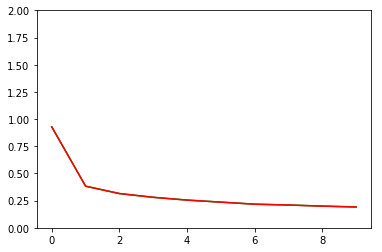

Validation Loss


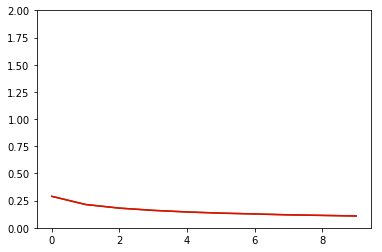

In [8]:
print("Loss")
plt.plot(learnHistSimple.history['loss'], color='red')
plt.ylim([0, 2])
plt.show()
print("Validation Loss")
plt.plot(learnHistSimple.history['val_loss'], color='red')
plt.ylim([0, 2])
plt.show()

**Answer**: The validation accuracy still improved in the last training epoch by 0.2% thus the network did not completely converge so far. Training it for 5 more epochs should let it converge completely.

Now we train a simple cnn on the small data that only contains the digits 8 and 9. To do so we first of all create the cnn:

In [9]:
cnnModelSmallDataset = getSimpleCNN(2)
cnnModelSmallDataset.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 26, 26, 32)        320       
_________________________________________________________________
max (MaxPooling2D)           (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

Then we can train the model:

In [10]:
batch_size = 128
encoder = LabelEncoder().fit(y_train_8and9)
oneHotLabelTrain = np_utils.to_categorical(encoder.transform(y_train_8and9), len(np.unique(y_train_8and9)))
oneHotLabelTest  = np_utils.to_categorical(encoder.transform(y_test_8and9), len(np.unique(y_test_8and9)))
learnHistSimple = cnnModelSmallDataset.fit(x_train_8and9,oneHotLabelTrain,validation_data=(x_test_8and9,oneHotLabelTest),
                                  batch_size=batch_size,
                                  epochs=10)

Train on 20 samples, validate on 1983 samples
Epoch 1/10
20/20 [==============================] - 0s - loss: 0.7385 - acc: 0.5500 - val_loss: 0.6994 - val_acc: 0.4458
Epoch 2/10
20/20 [==============================] - 0s - loss: 0.6501 - acc: 0.6500 - val_loss: 0.6937 - val_acc: 0.4907
Epoch 3/10
20/20 [==============================] - 0s - loss: 0.7369 - acc: 0.3500 - val_loss: 0.6875 - val_acc: 0.5124
Epoch 4/10
20/20 [==============================] - 0s - loss: 0.7088 - acc: 0.5000 - val_loss: 0.6805 - val_acc: 0.5199
Epoch 5/10
20/20 [==============================] - 0s - loss: 0.6699 - acc: 0.7000 - val_loss: 0.6752 - val_acc: 0.5356
Epoch 6/10
20/20 [==============================] - 0s - loss: 0.7105 - acc: 0.4500 - val_loss: 0.6691 - val_acc: 0.5240
Epoch 7/10
20/20 [==============================] - 0s - loss: 0.6937 - acc: 0.4500 - val_loss: 0.6634 - val_acc: 0.5245
Epoch 8/10
20/20 [==============================] - 0s - loss: 0.6285 - acc: 0.6500 - val_loss: 0.6575 - va

<b>Using pretrained weights</b>

If we define a neural net using keras we can initialize all the weights for the different layers with some weights of a different neural network (using the argument weights during initilization). To illustrate this look at the example above, where 3 different models are created. The first 2 models are initialized at random where the weights of the third model are the same as the weights for the first neural net.

In [5]:
net1 = Sequential()
net1.add(Dense(100,input_shape=[100,]))
net1.add(Dense(1))
net1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
net1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


In [6]:
net2 = Sequential()
net2.add(Dense(100,input_shape=[100,]))
net2.add(Dense(1))
net2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
net2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


In [7]:
net3 = Sequential()
net3.add(Dense(100,input_shape=[100,],weights=net1.layers[0].get_weights()))
net3.add(Dense(1,weights=net1.layers[1].get_weights()))
net3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
net3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


<b>Exercise 3:</b>  
Create 10 random test instances for the neural nets net1,net2 and net3 (a matirx with dimension 10 x 100). What is the outcome for the 3 different nets?

In [11]:
testInstances = np.random.random(size=(10, 100))
predict1 = net1.predict(testInstances)
predict2 = net2.predict(testInstances)
predict3 = net3.predict(testInstances)

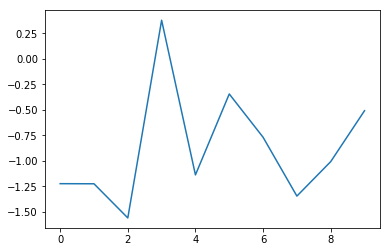

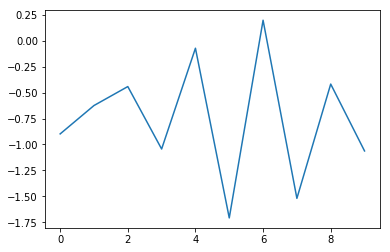

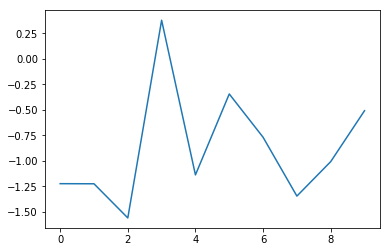

In [21]:
plt.plot(predict1)
plt.show()
plt.plot(predict2)
plt.show()
plt.plot(predict3)
plt.show()

<b>Exercise 4:</b> 

Create a cnn like the function 'getSimpleCNN' does, but use as weights for initialization the weights of the pretrained model 'cnnModel' for the convolution, the max pooling and the first dense layer.

In [15]:
nb_filters_one = 32
nb_filters_two = 64
nb_conv = 3
nb_pool = 2
dense_size = 128
nb_classes = 2

cnnModelDomainAdaptation = Sequential()
cnnModelDomainAdaptation.add(Conv2D(nb_filters_one, kernel_size=(nb_conv, nb_conv),
                 activation='relu', input_shape=input_shape,name='conv', weights=cnnModel.layers[0].get_weights()))
#cnnModel.add(Conv2D(nb_filters_two, (nb_conv, nb_conv), activation='relu'))
cnnModelDomainAdaptation.add(MaxPooling2D(pool_size=(nb_pool, nb_pool),name='max', weights=cnnModel.layers[1].get_weights()))
cnnModelDomainAdaptation.add(Dropout(0.25))
cnnModelDomainAdaptation.add(Flatten())
cnnModelDomainAdaptation.add(Dense(dense_size, activation='relu',name='dense', weights=cnnModel.layers[4].get_weights()))
cnnModelDomainAdaptation.add(Dropout(0.5))
cnnModelDomainAdaptation.add(Dense(nb_classes, activation='softmax'))

cnnModelDomainAdaptation.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
cnnModelDomainAdaptation.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 26, 26, 32)        320       
_________________________________________________________________
max (MaxPooling2D)           (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total para

Now, we train the new model using the pretrained weights for initialization.

In [16]:
batch_size = 128
encoder = LabelEncoder().fit(y_train_8and9)
oneHotLabelTrain = np_utils.to_categorical(encoder.transform(y_train_8and9), len(np.unique(y_train_8and9)))
oneHotLabelTest  = np_utils.to_categorical(encoder.transform(y_test_8and9), len(np.unique(y_test_8and9)))
learnHistAdaption = cnnModelDomainAdaptation.fit(x_train_8and9,oneHotLabelTrain,validation_data=(x_test_8and9,oneHotLabelTest),
                                  batch_size=batch_size,
                                  epochs=10)

Train on 20 samples, validate on 1983 samples
Epoch 1/10
20/20 [==============================] - 0s - loss: 0.8965 - acc: 0.5500 - val_loss: 0.4903 - val_acc: 0.7811
Epoch 2/10
20/20 [==============================] - 0s - loss: 0.4990 - acc: 0.8500 - val_loss: 0.3860 - val_acc: 0.8971
Epoch 3/10
20/20 [==============================] - 0s - loss: 0.5078 - acc: 0.8000 - val_loss: 0.3581 - val_acc: 0.8830
Epoch 4/10
20/20 [==============================] - 0s - loss: 0.3754 - acc: 0.7500 - val_loss: 0.3508 - val_acc: 0.8684
Epoch 5/10
20/20 [==============================] - 0s - loss: 0.2805 - acc: 0.8500 - val_loss: 0.3448 - val_acc: 0.8538
Epoch 6/10
20/20 [==============================] - 0s - loss: 0.3340 - acc: 0.9000 - val_loss: 0.4386 - val_acc: 0.7796
Epoch 7/10
20/20 [==============================] - 0s - loss: 0.3706 - acc: 0.7500 - val_loss: 0.3382 - val_acc: 0.8522
Epoch 8/10
20/20 [==============================] - 0s - loss: 0.1717 - acc: 0.9500 - val_loss: 0.3534 - va

<b>Exercise 5:</b>
Compare the two models trained above for recognizing the digits 8 and 9 (cnnModel vs. cnnModelDomainAdaptation) with each other. Which model would you prefer?

<b>Answer:</b> The adapted model (red) starts with a higher accuracy and a lower loss. While it still seems to fluctuate, both metrics are stabilizing which shows that the model also converges. It's still unclear which model would outperform the other one after converging. However, from the learning curves after 10 epochs I'd prefer the model that uses the pre-trained weights.

Validation Loss


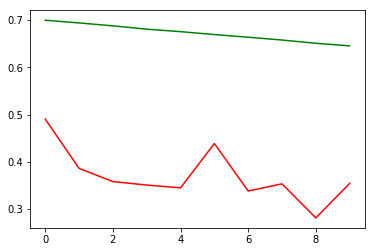

Validation Accuracy


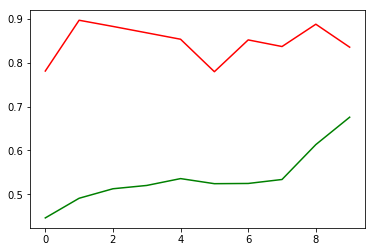

In [18]:
print("Validation Loss")
plt.plot(learnHistSimple.history['val_loss'], color='green')
plt.plot(learnHistAdaption.history['val_loss'], color='red')
plt.show()
print("Validation Accuracy")
plt.plot(learnHistSimple.history['val_acc'], color='green')
plt.plot(learnHistAdaption.history['val_acc'], color='red')
plt.show()

<b>2. Part: Autoencoder</b>

In the second part of this tutorial we build an autoencoder to denoise images. To do so we are now using the functional api of keras.

First of all we create a noisy data set.

<b>Exercise 6:</b>
Create a noisy dataset by adding noise to all the images from the training and testing data 'x_train' and 'x_test', respectively. Your dataset should then look like shown in the figure below.

<img src="files/noisy.png",width=600,height=600>

In [51]:
from skimage.util import random_noise
x_train_noisy = random_noise(x_train, mode='gaussian', seed=None, clip=True, var=0.1)
x_test_noisy = random_noise(x_test, mode='gaussian', seed=None, clip=True, var=0.1)

Now, test your noising code by looking at the first 10 images.

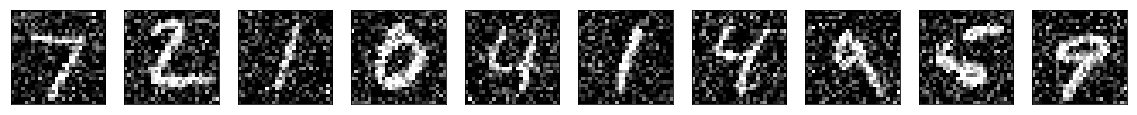

In [52]:
# show images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Now, lets define the the simplest autoencoder we can imagine. Here we try to encode the images with 32 floats. The input are the raw pixel values for the images as a flattened vector.

In [53]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Extract the encoder:

In [54]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

Extract the decoder:

In [55]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now we compile and train the autoencoder on the flattened images:

In [56]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_11 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [57]:
autoEncoderHist = autoencoder.fit(x_train_noisy.reshape(x_train_noisy.shape[0],28*28),
                x_train_noisy.reshape(x_train_noisy.shape[0],28*28),
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy.reshape(x_test_noisy.shape[0],28*28),
                                 x_test_noisy.reshape(x_test_noisy.shape[0],28*28)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.4700 - val_loss: 0.4417
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.4342 - val_loss: 0.4275
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.4255 - val_loss: 0.4231
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.4228 - val_loss: 0.4216
Epoch 5/10
60000/60000 [==============================] - 2s - loss: 0.4217 - val_loss: 0.4208
Epoch 6/10
60000/60000 [==============================] - 2s - loss: 0.4211 - val_loss: 0.4203
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.4202 - val_loss: 0.4192
Epoch 8/10
60000/60000 [==============================] - 2s - loss: 0.4195 - val_loss: 0.4188
Epoch 9/10
60000/60000 [==============================] - 2s - loss: 0.4192 - val_loss: 0.4185
Epoch 10/10
60000/60000 [==============================] - 2s - loss: 0.4190 - val_loss: 0.4183

In [58]:
# encode and decode some digits
encoded_imgs = encoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0],28*28))
decoded_imgs = decoder.predict(encoded_imgs)

<b>Exercise 7:</b>
Plot the first 10 images from the noisy test set and their denoised prediction.

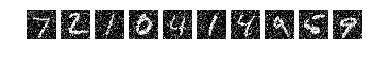

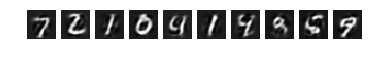

In [66]:
# Noisy test set
for i in range(num_instances):
    plt.subplot(2, num_instances, i + 1)
    plt.axis('off')
    plt.imshow(x_test_noisy[i, :, :, 0])
plt.show()

# Denoised prediction
for i in range(num_instances):
    plt.subplot(2, num_instances, i + 1)
    plt.axis('off')
    plt.imshow(decoded_imgs[i].reshape(28, 28))
plt.show()

Can we do better when giving the exact objective of trying to build a model the creates for a noisy input its denoised version?

In [68]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

autoEncoderHist = autoencoder.fit(x_train_noisy.reshape(x_train_noisy.shape[0],28*28),
                x_train.reshape(x_train_noisy.shape[0],28*28),
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy.reshape(x_test_noisy.shape[0],28*28),
                                 x_test.reshape(x_test.shape[0],28*28)))



# encode and decode some digits
encoded_imgs = encoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0],28*28))
decoded_imgs = decoder.predict(encoded_imgs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_13 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.2309 - val_loss: 0.1689
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.1513 - val_loss: 0.1353
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.1290 - val_loss: 0.1211
Epoch 4/10
60000/60000 [==============================] - 2s - loss

<b>Excercise 8:</b>

Add your code from Excersice 7 and look at the new results. Are they better now? And if yes, why?

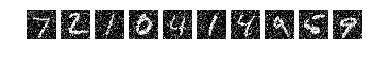

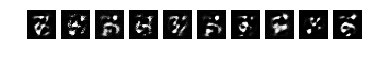

In [69]:
# Noisy test set
for i in range(num_instances):
    plt.subplot(2, num_instances, i + 1)
    plt.axis('off')
    plt.imshow(x_test_noisy[i, :, :, 0])
plt.show()

# Denoised prediction
for i in range(num_instances):
    plt.subplot(2, num_instances, i + 1)
    plt.axis('off')
    plt.imshow(decoded_imgs[i].reshape(28, 28))
plt.show()

<b>Additional Exercise:</b>

Try to build a autoencoder using CNN's.

In [95]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(14, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(7, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)
print("Decoded shape: ", K.int_shape(encoded))

x = Conv2D(7, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(14, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (5, 5), activation="sigmoid", padding="same")(x)
print("Decoded shape: ", K.int_shape(decoded))

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Decoded shape:  (None, 7, 7, 7)
Decoded shape:  (None, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 28, 28, 14)        140       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 14)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 14, 14, 7)         889       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 7)           0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 7, 7, 7)           448       
_________________________________________________________________
up_samplin

In [ ]:
autoEncoderCNNHist = autoencoder.fit(x_train_noisy,
                x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy,
                                 x_test))

In [99]:
# encode and decode some digits
encoded_imgs = encoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0],28*28))
decoded_imgs = decoder.predict(encoded_imgs)

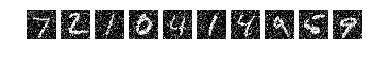

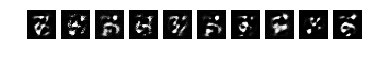

In [100]:
# Noisy test set
for i in range(num_instances):
    plt.subplot(2, num_instances, i + 1)
    plt.axis('off')
    plt.imshow(x_test_noisy[i, :, :, 0])
plt.show()

# Denoised prediction
for i in range(num_instances):
    plt.subplot(2, num_instances, i + 1)
    plt.axis('off')
    plt.imshow(decoded_imgs[i].reshape(28, 28))
plt.show()